In [1]:
import numpy as np
import matplotlib.pyplot as plt

from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from aeons.lm_partial import analytic_lm_params, X_end_formula, analytic_lm, params_from_d
from aeons.covariance import X_mu, X_Sigmainv, logX_mu, points_at_iteration
from aeons.true_distribution import generate_Xs, nk_dead, nk_dead_live, nk_live
from aeons.likelihoods import likelihood, linear_like, quad_like, log_like, simple_like, middle_like, full_like
linear, quad, log = linear_like(), quad_like(), log_like()
simple, middle, full = simple_like(), middle_like(), full_like()
from aeons.models import LS, CG
from aeons.endpoint import EndModel

#### **Functions**

In [3]:
from scipy.special import gamma
from scipy.integrate import quad
from scipy.special import loggamma
def cauchy(X, theta):
    d, g = theta
    return 1/( 1 + (X**(2/d))/(g**2) )**((1+d)/2)
def logcauchy(X, theta):
    return np.log(cauchy(X, theta))

In [34]:
from aeons.toy_samples import gaussian_samples
from scipy.special import gammainc, gamma, logsumexp, loggamma
def logZlive(Xi, theta):
    logLmax, d, sigma = theta
    prefactor = logLmax + d/2*np.log(2) + d*np.log(sigma) + np.log(d/2)
    loggammainc = np.log( gammainc( d/2 , Xi**(2/d)/(2*sigma**2) ) * gamma(d/2) )
    return prefactor + loggammainc

def dlogX_calc(logX):
    # Returns dlogX from outside in
    logXp = np.roll(logX, 1)
    logXp[0] = 0
    logXm = np.roll(logX, -1)
    logXm[-1] = -np.inf
    dlogX = np.log(1 - np.exp(logXm-logXp)) + logXp - np.log(2)
    return dlogX

def logZ_trapz(logL, logX):
    dlogX = dlogX_calc(logX)
    return logsumexp(dlogX + logL)

def logXf_formula(logZlive, logZdead, logLmax):
    return logsumexp(logZlive, logZdead - logLmax)

def logXf_formula_gaussian(theta, epsilon=1e-3):
    _, d, sigma = theta
    return d/2*np.log(2) + d * np.log(sigma) + loggamma(1 + d/2) + np.log(epsilon)

In [241]:
def plot_like(loglike, theta, logX_min=-40, samples=None):
    logXarray = np.linspace(logX_min, 0, 1000)
    Xarray = np.exp(logXarray)
    Larray = np.exp(loglike(Xarray, theta))
    fig, ax1 = plt.subplots(figsize=(6.7, 3))
    ax2 = plt.twinx(ax1)
    ax1.plot(logXarray, Larray, lw=1, color='black')
    ax2.plot(logXarray, Larray*Xarray)#, alpha=0.2)
    if samples:
        Xsamples, ndead = samples
        ax2.axvline(x=Xsamples[ndead], lw=.5, ls='--')
        ax2.axvline(x=Xsamples[-1], lw=.5, ls='--')

def minimise_bandwidth(logL, X_mean, ndead, alphas, x0):
    theta_best = None
    logZi = -np.inf
    for alpha in alphas:
        startf = int(ndead * (1 - alpha))
        logLf = logL[startf:]
        X_meanf = X_mean[startf:]
        ls = LS(logL, full, X_mean)
        theta = analytic_lm_params(logLf, X_meanf, x0)
        try:
            logZf = ls.logZ(theta)
        except RuntimeWarning:
            print(theta, 'warning', alpha)
        if logZf > logZi:
            theta_best = theta
    return theta_best

#### **Single iterations**

##### Single iteration, using mean

In [196]:
nlive = 500
ndead = 11500
nk = nk_dead_live(nlive, ndead)
X_mean = X_mu(nk)
logX_mean = np.log(X_mean)
X = generate_Xs(nk)
logL = np.log(cauchy(X_mean, cauchy_params))

cauchy_params = [4, 1e-3]
logXarray = np.flip(np.linspace(-50, 0, 1000))
Xarray = np.exp(logXarray)
Larray = cauchy(Xarray, cauchy_params)

In [197]:
theta_l = analytic_lm_params(logL[ndead:], X_mean[ndead:], 1)
_, d, sigma = theta_l

def logXend(d, sigma, epsilon=1e-3):
    return d/2 * np.log(2) + d * np.log(sigma) + loggamma(1 + d/2) + np.log(epsilon)

logXend(d, sigma)

-38.00023893155651

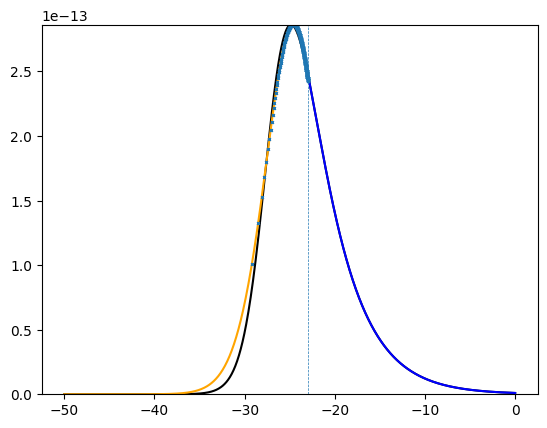

In [198]:
k_X = np.argmax(Xarray < X_mean[ndead])
fig, ax1 = plt.subplots()
# ax2 = plt.twinx(ax1)
ax1.plot(logXarray, Larray*Xarray, color='black')
ax1.plot(logX_mean[:ndead], np.exp(logL[:ndead])*X_mean[:ndead], color='blue')
ax1.axvline(logXarray[k_X], lw=0.5, ls='--')
ax1.set_ylim(0, np.max(Larray*Xarray))
ax1.plot(logXarray[k_X:], np.exp(full.func(Xarray, theta_l))[k_X:]*Xarray[k_X:], color='orange')
ax1.plot(logX_mean[ndead:], np.exp(full.func(X_mean[ndead:], theta_l))*X_mean[ndead:], 'x', ms=2)

##### Single iteration using typical set

In [202]:
nlive = 500
ndead = 5000
nk = nk_dead_live(nlive, ndead)
X_mean = X_mu(nk)
logX_mean = np.log(X_mean)
X = generate_Xs(nk)
logL = np.log(cauchy(X_mean, cauchy_params))

cauchy_params = [4, 1e-3]
logXarray = np.flip(np.linspace(-50, 0, 1000))
Xarray = np.exp(logXarray)
Larray = cauchy(Xarray, cauchy_params)

In [203]:
X = generate_Xs(nk)
theta_l = analytic_lm_params(logL[ndead:], X[ndead:], 1)
_, d, sigma = theta_l

def logXend(d, sigma, epsilon=1e-3):
    return d/2 * np.log(2) + d * np.log(sigma) + loggamma(1 + d/2) + np.log(epsilon)

logXend(d, sigma)

-3049.519704489565

##### Single iteration with bandwidth

In [98]:
nlive = 500
ndead = 30000
nk = nk_dead_live(nlive, ndead)
X_mean = X_mu(nk)
logX_mean = logX_mu(nk)

cauchy_params = [5, 1e-4]
Xsample = generate_Xs(nk)
logLsample = logcauchy(Xsample, cauchy_params)

In [100]:
alphas = np.linspace(0, 1, 10)
theta_l = analytic_lm_params(logLsample[ndead:], X_mean[ndead:], 2)
theta_best = minimise_bandwidth(logLsample, X_mean, ndead, alphas, 2)
theta_best, theta_l

([36.55806721587532, 112.24711385238591, 0.07272394603455],
 [0.0003459805262462177, 5.397972857882775, 9.381861101966209e-05])

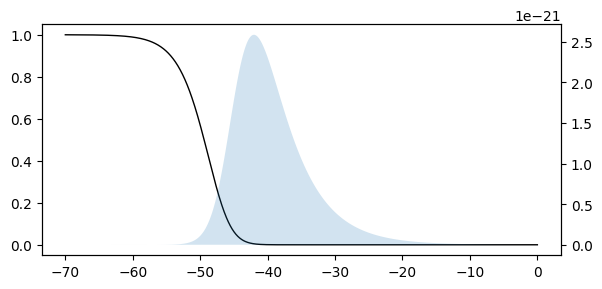

In [68]:
logXarray = np.flip(np.linspace(-70, 0, 1000))
Xarray = np.exp(logXarray)
logLarray = logcauchy(Xarray, cauchy_params)
logZtrue = logZ_trapz(logLarray, logXarray)
plot_like(logcauchy, cauchy_params, -70)

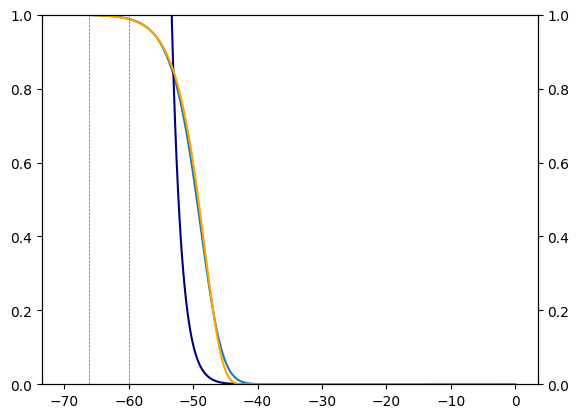

In [103]:
fig, ax1 = plt.subplots()
ax2 = plt.twinx(ax1)
ax1.plot(logXarray, cauchy(Xarray, cauchy_params))
ax1.plot(logXarray, np.exp(full.func(Xarray, theta_best)), color='navy')
ax1.plot(logXarray, np.exp(full.func(Xarray, theta_l)), color='orange')
# ax1.plot(np.log(X_mean), np.exp(logLsample), 'x')
# ax1.set_xlim(-47, -39)
ax1.set_ylim(0, 1)
ax1.axvline(x=np.log(X_mean[ndead]), ls='--', lw=.5)
ax1.axvline(x=np.log(X_mean[-1]), ls='--', lw=.5)

In [64]:
logXf_formula_gaussian(theta_best) * (-nlive)

2499325.3131520688

In [80]:
logXf_formula_gaussian(theta_l) * (-nlive)

82383.79352729664

#### **Across all iterations**

##### Making my own Cauchy

In [2]:
from anesthetic.examples.utils import random_ellipsoid
from anesthetic import NestedSamples
from anesthetic.samples import merge_nested_samples

def cauchy_samples(nlive, ndims, gamma=0.1, R=1, logLmin=-1e-2):
    def logLike(x):
        return - (1+ndims)/2  *np.log( 1 + (x**2).sum(axis=-1)/(gamma**2) )
        
    def random_sphere(n):
        return random_ellipsoid(np.zeros(ndims), np.eye(ndims), n)

    samples = []
    r = R
    logL_birth = np.ones(nlive) * -np.inf
    logL = logL_birth.copy()
    while logL.min() < logLmin:
        points = r * random_sphere(nlive)
        logL = logLike(points)
        samples.append(NestedSamples(points, logL=logL, logL_birth=logL_birth))
        logL_birth = logL.copy()
        r = (points**2).sum(axis=-1, keepdims=True)**0.5

    samples = merge_nested_samples(samples)
    samples.logL
    logLend = samples[samples.nlive >= nlive].logL.max()
    return samples[samples.logL_birth < logLend].recompute()

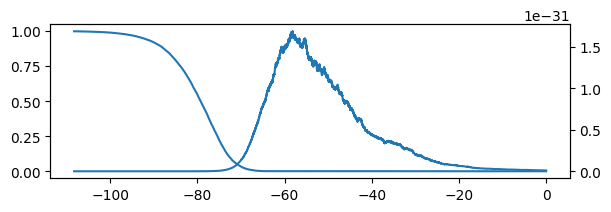

In [3]:
nlive = 500
d, g = 10, 1e-3
theta_cauchy = [d, g]
samples = cauchy_samples(nlive, d, g)
model = EndModel(samples)
model.plot_lx()

In [4]:
logXf_true = model.logXf_true(100, 0.3)

In [59]:
len(samples)

51256

In [11]:
# model.minimise(ndead, Nset=25)
iterations = np.linspace(1000, 50000, 15).astype(int)
alphas = np.arange(0, 1.1, 0.1)
logXfs, logXfs_std = model.logXfs(iterations, Nset=25)

(0.0, 44089.525156688775)

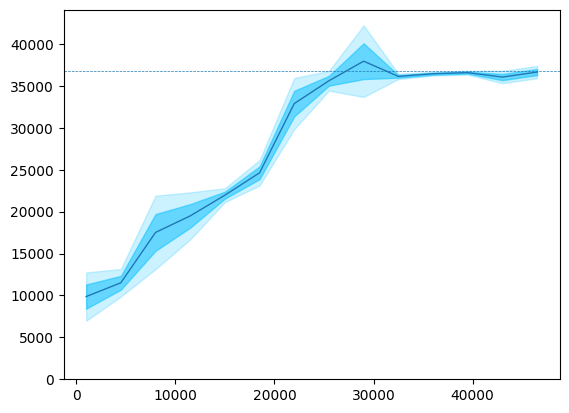

In [12]:
plt.plot(iterations, logXfs * (-nlive), lw=1)
plt.axhline(logXf_true * (-nlive), lw=.5, ls='--')
plt.fill_between(iterations, (logXfs - logXfs_std) * (-nlive), (logXfs + logXfs_std) * (-nlive), alpha=0.5, color='deepskyblue')
plt.fill_between(iterations, (logXfs - 2*logXfs_std) * (-nlive), (logXfs + 2*logXfs_std) * (-nlive), alpha=0.2, color='deepskyblue')
plt.ylim(0, logXf_true * (-nlive) * 1.2)

In [13]:
from aeons.tools import pickle_dump
pickle_dump('bandwidth_endpoints/cauchy_endpoints.pickle', [iterations, logXfs, logXfs_std])

In [14]:
pickle_dump('bandwidth_endpoints/cauchy_samples.pickle', samples)

In [9]:
model.logXf_true(200, 0.3)

-52.26575165287915

##### Single iteration

In [164]:
ndead = 2000
points = points_at_iteration(samples, ndead)
nk = np.array(points.nlive)
logL = np.array(points.logL)
X_mean = X_mu(nk)
analytic_lm_params(logL[ndead:], X_mean[ndead:], 1)

[-29.150836050539183, 32.426315472756535, 0.13525026955406078]

##### Without bandwidth
[5, 1e-4] doesn't converge until about 70% of the way through

[10, 1e-2] doesn't until about halfway through

In [254]:
nlive = 500
d, g = 10, 1e-2
theta_cauchy = [d, g]
samples = cauchy_samples(nlive, d, g)

In [271]:
nlive = 1
d, g = 50, 1e-2
theta_cauchy = [d, g]
samples = cauchy_samples(nlive, d, g)

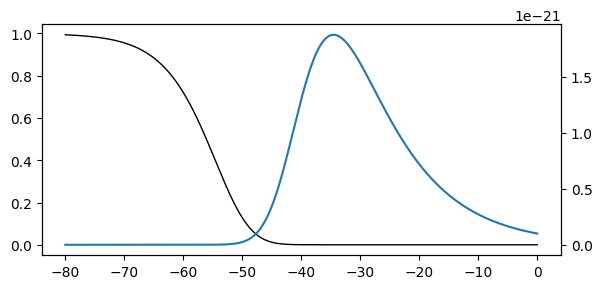

In [256]:
plot_like(logcauchy, theta_cauchy, -80)

(0.0, 100000.0)

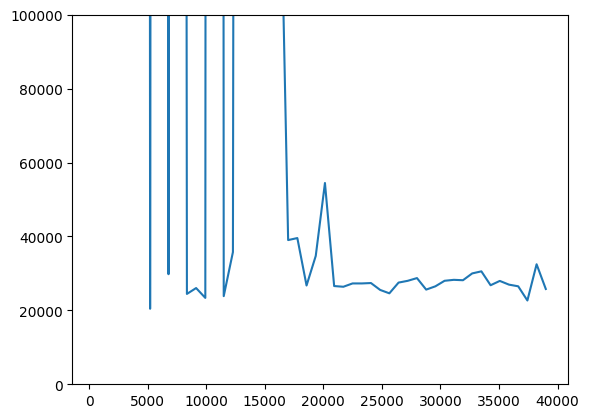

In [261]:
# Without bandwidth
iterations = np.linspace(500, 39000, 50)
endpoints = np.zeros_like(iterations)
thetas = []
for i, ndead in enumerate(iterations):
    ndead = int(ndead)
    points = points_at_iteration(samples, ndead)
    nk = np.array(points.nlive)
    logL = np.array(points.logL)
    X_mean = X_mu(nk)
    theta_l = analytic_lm_params(logL[ndead:], X_mean[ndead:], 1)
    endpoints[i] = logXf_formula_gaussian(theta_l) * (-nlive)
    thetas.append(theta_l)
plt.plot(iterations, endpoints)
# plt.axhline(y=endpoint_true)
plt.ylim(0, 100000)

(0.0, 1.5)

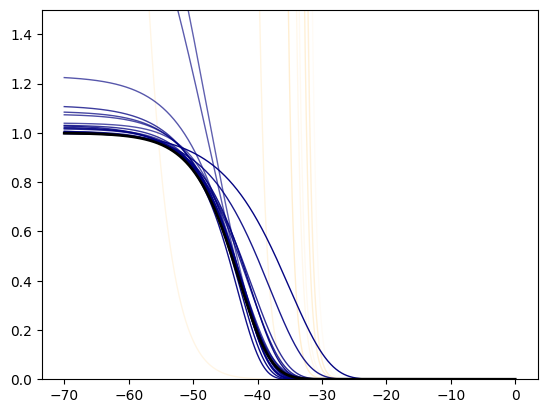

In [250]:
for i, theta in enumerate(thetas):
    if i < 10:
        plt.plot(logXarray, np.exp(full.func(Xarray, theta)), lw=1, alpha=0.02*i, color='orange')
    elif (i > 30):
        plt.plot(logXarray, np.exp(full.func(Xarray, theta)), lw=1, alpha=0.02*i, color='navy')
plt.plot(logXarray, cauchy(Xarray, theta_cauchy), lw=2, color='black')
plt.ylim(0, 1.5)

##### With bandwidth - does not work well

In [251]:
iterations = np.linspace(500, 30000, 50)
endpoints = np.zeros_like(iterations)
alphas = np.linspace(0, 0.95, 5)
for i, ndead in enumerate(iterations):
    ndead = int(ndead)
    points = points_at_iteration(samples, ndead)
    nk = np.array(points.nlive)
    logL = np.array(points.logL)
    X_mean = X_mu(nk)
    theta_l = minimise_bandwidth(logL, X_mean, ndead, alphas, 10);
    endpoints[i] = logXf_formula_gaussian(theta_l) * (-nlive)

(0.0, 100000.0)

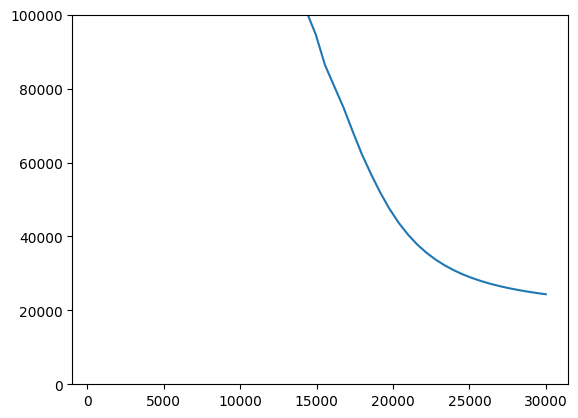

In [253]:
plt.plot(iterations, endpoints)
# plt.axhline(y=endpoint_true)
plt.ylim(0, 100000)

#### Figure production

In [19]:
format = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 11pt font in plots, to match 11pt font in document
    "axes.labelsize": 9,
    "font.size": 9,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 7,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    'axes.linewidth': 0.5,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'patch.linewidth': 0.5,
    'legend.frameon': False
}
plt.rcParams.update(format)

##### Endpoints

In [16]:
nlive = 500
samples = pickle_in('bandwidth_endpoints/cauchy_samples.pickle')
iterations, logXfs, logXfs_std = pickle_in('bandwidth_endpoints/cauchy_endpoints.pickle')
model = EndModel(samples)
Nfs, Nfs_std = logXfs * (-nlive), logXfs_std * (-nlive)

In [17]:
logXf_true = model.logXf_true(100, 0.5)
Nf_true = logXf_true * (-nlive)

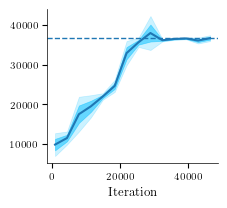

In [23]:
plt.figure(figsize=(2.2, 2))
plt.plot(iterations, Nfs)
plt.fill_between(iterations, Nfs - Nfs_std, Nfs + Nfs_std, alpha=0.5, color='deepskyblue')
plt.fill_between(iterations, Nfs - 2*Nfs_std, Nfs + 2*Nfs_std, alpha=0.2, color='deepskyblue')
plt.axhline(y=Nf_true, lw=1, ls='--')
# plt.ylim(35000, 90000)
# plt.xlim(0, 38000)
# plt.ylabel('Endpoint prediction')
plt.xlabel('Iteration')
plt.savefig('../../../report/figures/cauchy_endpoints.pdf', format='pdf', bbox_inches='tight')

In [24]:
samples.D_KL()

47.87528983180757

##### Fits

In [ ]:
logXarray = np.flip(np.linspace(model.logX_mean[-1], 0, 1000))
Xarray = np.exp(logXarray)

ndead = 3600
logL, nk, logZdead = model.data(ndead)
X_mean = X_mu(nk)
logX_mean = logX_mu(nk)
theta_l = analytic_lm_params(logL[ndead:], X_mean[ndead:], 1)
theta = model.minimise(ndead, Nset=25)

fig, ax1 = plt.subplots()
ax2 = plt.twinx(ax1)
ax2.plot(model.logX_mean, np.exp(model.logL) * np.exp(model.logX_mean), lw=1, color='black')
logLmaxm, dm, sigmam = np.median(theta, axis=0)
intercept = logLmaxm
for t in theta:
    logLmax, d, sigma = t
    ax1.plot(logXarray, np.exp(full.func(Xarray, [0, d, sigma])), lw=1, color='deepskyblue', alpha=0.3)

# ax1.plot(logXarray, Larray, lw=2, color='black')
ax1.plot(model.logX_mean, np.exp(model.logL), lw=2, color='black')
# ax1.plot(logXarray, np.exp(full.func(Xarray, [intercept, dm, sigmam])), lw=2, color='blue', alpha=1)
# ax1.plot(np.percentile(logX_mean[ndead:-1], [8, 50, 92]), [0, 0, 0], 'x', ms=8, color='red')
ax1.axvline(x=np.percentile(logX_mean[ndead:-1], 8), lw=1, ls='--')
ax1.axvline(x=np.percentile(logX_mean[ndead:-1], 92), lw=1, ls='--')
ax1.set_ylim(-0.05, 1.05);
ax1.set_xticks([]);
ax1.set_yticks([]);

In [42]:
pickle_dump(f'cauchy_fits/cauchy{ndead}.pickle', theta)

In [50]:
samples = pickle_in('bandwidth_endpoints/cauchy_samples.pickle')
model = EndModel(samples)
thetas = []
ndeads = [3600, 17000, 25000, 33000]
for ndead in ndeads:
    theta = pickle_in(f'cauchy_fits/cauchy{ndead}.pickle')
    thetas.append(theta)

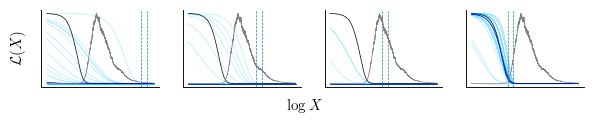

In [58]:
logXarray = np.flip(np.linspace(model.logX_mean[-1], 0, 1000))
Xarray = np.exp(logXarray)

fig, axs = plt.subplots(1, 4, figsize=(7, 1))
for i, ax in enumerate(axs):
    ndead = ndeads[i]
    nk = model.data(ndead)[1]
    logX_mean = logX_mu(nk)
    logLmaxm, dm, sigmam = np.median(thetas[i], axis=0)
    intercept = 0 # if i < 3 else 0
    for t in thetas[i]:
        logLmax, d, sigma = t
        ax.plot(logXarray, np.exp(full.func(Xarray, [intercept, d, sigma])), lw=.5, color='deepskyblue', alpha=0.3)
    ax.plot(model.logX_mean, np.exp(model.logL), lw=.5, color='black')
    ax.plot(logXarray, np.exp(full.func(Xarray, [intercept, dm, sigmam])), lw=.5, color='blue', alpha=1)
    ax.axvline(x=np.percentile(logX_mean[ndead:-1], 0), lw=.5, ls='--')
    ax.axvline(x=np.percentile(logX_mean[ndead:-1], 90), lw=.5, ls='--')
    ax.set_xticks([])
    ax.set_yticks([])

    ax1 = plt.twinx(ax)
    ax1.plot(model.logX_mean, np.exp(model.logL) * np.exp(model.logX_mean), lw=.5, color='gray')
    ax1.set_yticks([])
fig.supxlabel('$\log X$', y=-0.15)
fig.supylabel('$\mathcal{L}(X)$', x=0.08)
plt.savefig('../../../report/figures/cauchy_fits.pdf', format='pdf', bbox_inches='tight')